In [1]:
%matplotlib widget

import sys
sys.path.append("./../scripts")
import PandemiXFunctions as pf
import PandemiXModelFunctions as pmf

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
             
             
from scipy.integrate import cumtrapz
# int_I = cumtrapz(np.exp(u_H*ts)*Is,ts, initial=0)
# Hs = np.exp(-u_H*ts) * (r_chr*pars_full['gamma']*int_I + k) 

In [2]:
# Define paths
rootdir_data = os.getcwd() +"/../DanskeData/" 

path_data = rootdir_data + "ssi_data/"
path_dash = rootdir_data + "ssi_dashboard/"
path_vacc = rootdir_data + "ssi_vacc/"

path_figs = os.getcwd() +"/../Figures/" 

In [3]:
dfOmikron = pd.read_excel(rootdir_data+'Omikron.xlsx')
dfOmikron.Dato = pd.to_datetime(dfOmikron.Dato)


latestsubdir = list(os.walk(path_dash))[0][1][-1]
latestdir = path_dash + latestsubdir

df = pd.read_csv(latestdir+'/Regionalt_DB/24_reinfektioner_daglig_region.csv',delimiter=';',encoding='latin1')
df['Prøvedato'] =  pd.to_datetime(df['Prøvedato'],format='%Y-%m-%d')

df = df[df.Region == 'Hovedstaden']
# df = df[df.Region == 'Nordjylland']
dfTot = df.groupby('Prøvedato').sum()
dfRe = df[df['Type af tilfælde (reinfektion eller første infektion)'] == '1.Reinfektion'].groupby('Prøvedato').sum()


In [4]:
dfCorr = pd.read_csv(rootdir_data+'/CopenhagenTestCorrected.csv')
dfCorr['Dato'] = pd.to_datetime(dfCorr['Dato'])

In [5]:
dfOmikronShort = dfOmikron.iloc[1:45]
dfOmikronShort
oDay = dfOmikronShort.Dato 
oRate = dfOmikronShort.Ratio/100

# Extend in both directions
preDay = np.arange(dfTot.index[0],oDay.iloc[0],np.timedelta64(1,'D'))
preRate = np.zeros(preDay.shape)

postDay = np.arange(oDay.iloc[-1],dfTot.index[-1],np.timedelta64(1,'D'))
postRate = np.ones(postDay.shape)

# Concatenate arrays
oDay = np.concatenate([preDay,oDay,postDay])
oRate = np.concatenate([preRate,oRate,postRate])

In [6]:

oRate = np.concatenate([[0,0,0],pf.rnMean(oRate,7),[1,1,1]])

In [7]:
dfToUse = pd.DataFrame() 
dfToUse['Date'] = dfTot.index 
dfToUse['Total'] = (dfTot.infected ).values
dfToUse['Delta'] = (dfTot.infected*(1-oRate)).values
dfToUse['Omikron'] = (dfTot.infected*oRate).values
dfToUse['Reinfections'] = (dfRe.infected  ).values

df = dfToUse.copy()

In [31]:
dfToUse.Reinfections.sum()

64132

In [8]:
dfCorrToUse = dfCorr[dfCorr.Dato >= dfToUse.Date.values[0]]
correctIndex = dfCorrToUse['Index10000'].values

dfCorrected =  pd.DataFrame() 
dfCorrected['Date'] = dfTot.index 
dfCorrected['Total'] = correctIndex*(dfTot.infected ).values
dfCorrected['Delta'] = correctIndex*(dfTot.infected*(1-oRate)).values
dfCorrected['Omikron'] =correctIndex* (dfTot.infected*oRate).values
dfCorrected['Reinfections'] =correctIndex* (dfRe.infected  ).values

dfCorrected

,Date,Total,Delta,Omikron,Reinfections
0,2021-01-01,1221.798838,1.221799e+03,0.000000,2.132284
1,2021-01-02,975.810908,9.758109e+02,0.000000,1.164452
2,2021-01-03,829.572959,8.295730e+02,0.000000,0.000000
3,2021-01-04,857.210993,8.572110e+02,0.000000,2.419222
4,2021-01-05,716.819678,7.168197e+02,0.000000,2.597173
...,...,...,...,...,...
419,2022-02-24,7516.255647,1.668944e-12,7516.255647,748.487253
420,2022-02-25,7626.033257,1.693320e-12,7626.033257,709.636240
421,2022-02-26,8928.584022,0.000000e+00,8928.584022,838.149602
422,2022-02-27,9083.944307,0.000000e+00,9083.944307,739.826392


(18901.0, 19072.15)

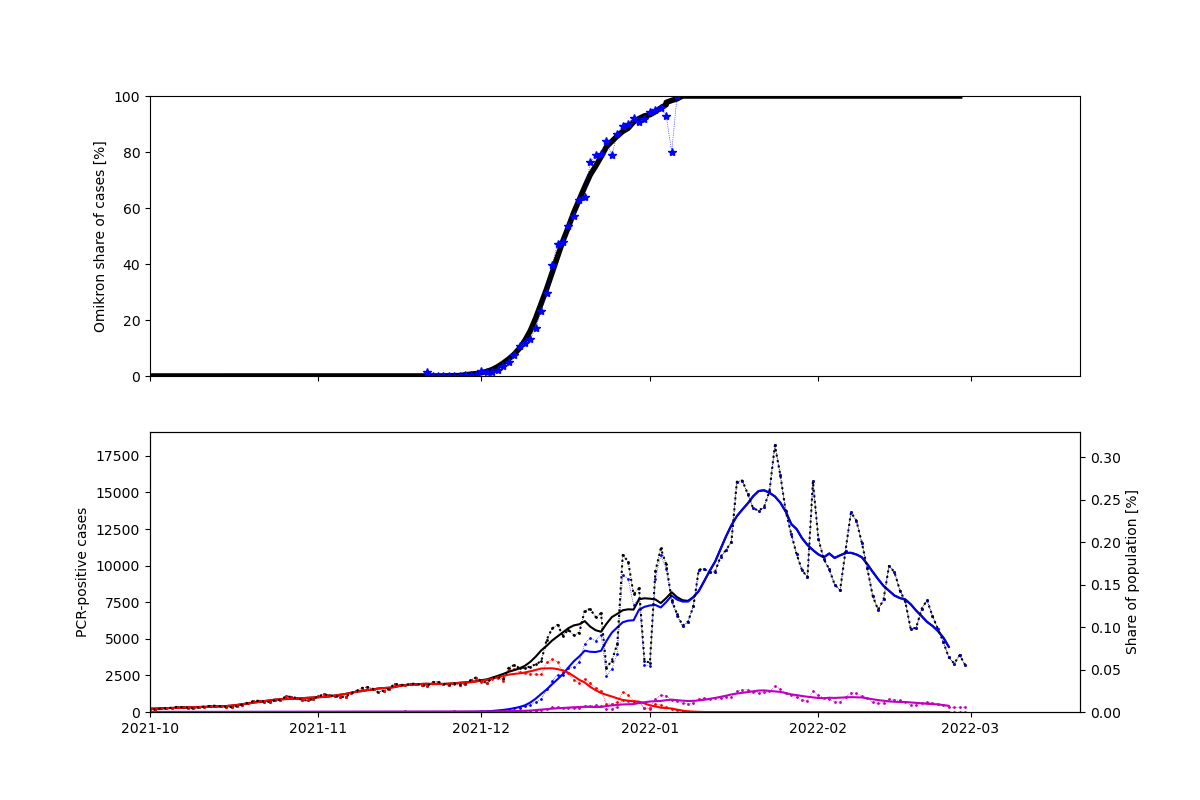

In [9]:
fig,(ax2,ax1) = plt.subplots(2,1,sharex=True)
ax2.plot(oDay,100*oRate,'k',linewidth=4,label='Ratio of Omikron-cases (running mean)')
# ax2.plot(rnTime(oDay,7),rnMean(oRate,7))
ax2.plot(dfOmikron.Dato,dfOmikron.Ratio,'b*:',linewidth=0.5,label='Daily ratio (data)')

ax1_1 = ax1.twinx()
DKpop = 5800000
ax1_1.plot(dfTot.index,100*dfTot.infected/DKpop,'k:')
ax1.plot(dfTot.index,dfTot.infected,'k.:',markersize=2,linewidth=0.5,label='Total cases')
ax1.plot(dfTot.index,dfTot.infected*oRate,'b.:',markersize=2,linewidth=0.5,label='Omikron cases')
ax1.plot(dfTot.index,dfTot.infected*(1-oRate),'r.:',markersize=2,linewidth=0.5,label='Delta cases')
ax1.plot(dfRe.index,dfRe.infected,'m.:',markersize=2,linewidth=0.5,label='Reinfections')

ax1.plot(pf.rnTime(dfTot.index),pf.rnMean(dfTot.infected),'k')
ax1.plot(pf.rnTime(dfTot.index),pf.rnMean(dfTot.infected*oRate),'b')
ax1.plot(pf.rnTime(dfTot.index),pf.rnMean(dfTot.infected*(1-oRate)),'r')
ax1.plot(pf.rnTime(dfRe.index),pf.rnMean(dfRe.infected),'m')


ax1.set_ylim(bottom=0)
ax1_1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0,top=100)


ax2.set_ylabel('Omikron share of cases [%]')
ax1.set_ylabel('PCR-positive cases')
ax1_1.set_ylabel('Share of population [%]')

ax1.set_xlim(left=np.datetime64('2021-10'))

# Setup model

In [10]:

# df = df[df.Date >= np.datetime64('2021-10-01')]
# # df = df[df.Date >= np.datetime64('2021-09-15')]
# df = df.reset_index()
# DateRestrictions = np.where(df.Date == np.datetime64('2021-12-15'))[0][0]
# DateNewYears = np.where(df.Date == np.datetime64('2022-01-01'))[0][0]
# DateRestrictionsEnd = np.where(df.Date == np.datetime64('2022-01-15'))[0][0]



dfCorrected = dfCorrected[dfCorrected.Date >= np.datetime64('2021-10-01')]
# dfCorrected = dfCorrected[dfCorrected.Date >= np.datetime64('2021-09-15')]
dfCorrected = dfCorrected.reset_index()
DateRestrictions = np.where(dfCorrected.Date == np.datetime64('2021-12-15'))[0][0]
DateNewYears = np.where(dfCorrected.Date == np.datetime64('2022-01-01'))[0][0]
DateRestrictionsEnd = np.where(dfCorrected.Date == np.datetime64('2022-01-15'))[0][0]



In [11]:
# Reload PandemiXModelFunctions, in case changes have been made
import importlib 
importlib.reload(pmf)

<module 'PandemiXModelFunctions' from 'c:\\Users\\rakrpe\\GithubRepos\\PandemiX\\modelling\\PandemiXModelFunctions.py'>

In [12]:
# Initialize everything
DarkNumberRatio = 1.25
DarkNumberRatio = 1
DarkNumberRatio = 2

# DKpop = 5800000
# # Numbers for weeks 44, i.e. 2021-11-01
# numVacc = 4423398
# DKpop = 5889508


# Numbers from 2021-11-01 for Region Hovedstaden
popCount = 1857872
numVacc = 1365172
preInf = 183799
preInf = preInf * 0.95

# iniInf = DarkNumberRatio * df.Total[0:5].sum()/DKpop
# iniInf = DarkNumberRatio * (pf.rnMean(df.Total,7)[0:5]).sum()/DKpop
iniInf = DarkNumberRatio * (pf.rnMean(df.Total,7)[0:6]).sum()/DKpop
# iniVacc = 0.7 # Approximately DK's vaccinationsrate at the end of summer 2021
iniVacc = numVacc/popCount 
# iniImmu = 0.05 # Approximation. Should only be "natural immunity"
iniImmu = DarkNumberRatio * (preInf/popCount)
# iniImmu = 0.10 # Approximation. Should only be "natural immunity"
iniImmu = iniImmu * (1-iniVacc) # For splitting previous infections between vaccinated and susceptible

iniVacc = iniVacc * 0.95 # Assuming approximately 5% of vaccinations didn't provide immunity
# iniVacc = iniVacc * 0.925 # Assuming approximately 7.5% of vaccinations didn't provide immunity

V_0 = iniVacc 
IS_0 = 0
IV_0 = 0
Y_0 = iniInf
R01_0 = iniImmu
R10_0 = 0
I01_0 = 0
Y10_0 = 0
S_0 = 1 - V_0 - IS_0 - IV_0 - Y_0 - R01_0 - R10_0 - I01_0 - Y10_0 

init = {'S' : S_0,'V' : V_0,'IS' : IS_0,'IV' : IV_0,'Y' : Y_0,'R01' : R01_0,'R10' : R10_0,'I01' : I01_0,'Y10' : Y10_0}

# gammas = 1/7
gammas = 1/4.7
# gammas = 1/3.5
# gammas = 1/(5.5)
# gammas = 1/(2)
# beta_Y = 4.2*gammas
beta_Y = 4.5*gammas
beta_Y = 4.8*gammas
# beta_Y = 6.9*gammas
# beta_Y = 7.2*gammas
beta_I = 2*gammas
# beta_I = 1.5*gammas

pars = {'beta_IS_S' : beta_I,'beta_IV_S' : beta_I,'beta_I01_S' : beta_I,'beta_IS_V' : beta_I,'beta_IV_V' : beta_I,'beta_I01_V' : beta_I,'beta_IS_R01' : beta_I,'beta_IV_R01' : beta_I,'beta_I01_R01' : beta_I,'beta_Y_S' : beta_Y,'beta_Y10_S' : beta_Y,'beta_Y_R10' : beta_Y,'beta_Y10_R10' : beta_Y,'gamma_IS' : gammas,'gamma_IV' : gammas,'gamma_Y' : gammas,'gamma_I01' : gammas,'gamma_Y10' : gammas}

numDaysToSim = len(df.Date)    
tEnd = numDaysToSim+20
sch1 = pmf.Scheme('OmikronDeltaFull',init,pars,3,tEnd,Changes=[])


(0.0, 10000.0)

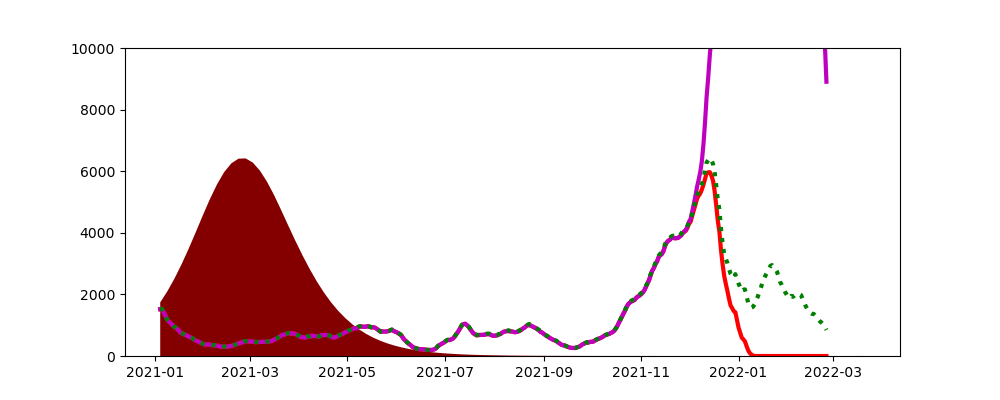

In [13]:
curSch = sch1
curSch.simulate()

curT = curSch.result.t
curDays = np.datetime64(df.iloc[0].Date)+np.array([np.timedelta64(int(np.round(x*24)),'h') for x in curT])

# plt.figure(figsize=(10,5))

fig,ax1 = plt.subplots(figsize=(10,4))

ax1.stackplot(curDays,
                DKpop*gammas*curSch.result.Y,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) + pf.rnMean(df.Delta,7)),':',color='g',linewidth=3)

ax1.set_ylim(top=10000,bottom=0)

In [14]:
# tLock = DateRestrictions
# # betaMult = 0.5
# # betaSet_Y_close = betaSet 
# # betaSet_I_close = betaSet 
# betaSet_Y_close = beta_Y * 0.5
# # betaSet_I_close = beta_I * 0.75
# betaSet_I_close = beta_I
# dictToSet = {'beta_IS_S' : betaSet_I_close,'beta_IV_S' : betaSet_I_close,'beta_I01_S' : betaSet_I_close,'beta_IS_V' : betaSet_I_close,'beta_IV_V' : betaSet_I_close,'beta_I01_V' : betaSet_I_close,'beta_IS_R01' : betaSet_I_close,'beta_IV_R01' : betaSet_I_close,'beta_I01_R01' : betaSet_I_close,'beta_Y_S' : betaSet_Y_close,'beta_Y10_S' : betaSet_Y_close,'beta_Y_R10' : betaSet_Y_close,'beta_Y10_R10' : betaSet_Y_close}
# betaSet = pmf.Change(tLock, SetParameters=dictToSet)

# sch2 = sch1.copy()
# sch2.addChange(betaSet)
# sch2.simulate()

In [15]:
tLock = DateRestrictions
betaMult_Y_close = 0.5
# betaMult_I_close = 0.625
betaMult_I_close = 0.75
dictToMult = {'beta_IS_S' : betaMult_I_close,'beta_IV_S' : betaMult_I_close,'beta_I01_S' : betaMult_I_close,'beta_IS_V' : betaMult_I_close,'beta_IV_V' : betaMult_I_close,'beta_I01_V' : betaMult_I_close,'beta_IS_R01' : betaMult_I_close,'beta_IV_R01' : betaMult_I_close,'beta_I01_R01' : betaMult_I_close,'beta_Y_S' : betaMult_Y_close,'beta_Y10_S' : betaMult_Y_close,'beta_Y_R10' : betaMult_Y_close,'beta_Y10_R10' : betaMult_Y_close}
betaMultChange = pmf.Change(tLock, MultiplyParameters=dictToMult)

sch2 = sch1.copy()
sch2.addChange(betaMultChange)

In [16]:
tLock = DateRestrictions + 7
betaMult_Y_close = 1
betaMult_I_close = 0.8
dictToMult = {'beta_IS_S' : betaMult_I_close,'beta_IV_S' : betaMult_I_close,'beta_I01_S' : betaMult_I_close,'beta_IS_V' : betaMult_I_close,'beta_IV_V' : betaMult_I_close,'beta_I01_V' : betaMult_I_close,'beta_IS_R01' : betaMult_I_close,'beta_IV_R01' : betaMult_I_close,'beta_I01_R01' : betaMult_I_close,'beta_Y_S' : betaMult_Y_close,'beta_Y10_S' : betaMult_Y_close,'beta_Y_R10' : betaMult_Y_close,'beta_Y10_R10' : betaMult_Y_close}
betaMultChange2 = pmf.Change(tLock, MultiplyParameters=dictToMult)

sch2 = sch1.copy()
sch2.addChange(betaMultChange)
sch2.addChange(betaMultChange2)

In [17]:
tLock = DateNewYears + 7
betaMult_Y_close = 1.05
betaMult_I_close = 1.05
dictToMult = {'beta_IS_S' : betaMult_I_close,'beta_IV_S' : betaMult_I_close,'beta_I01_S' : betaMult_I_close,'beta_IS_V' : betaMult_I_close,'beta_IV_V' : betaMult_I_close,'beta_I01_V' : betaMult_I_close,'beta_IS_R01' : betaMult_I_close,'beta_IV_R01' : betaMult_I_close,'beta_I01_R01' : betaMult_I_close,'beta_Y_S' : betaMult_Y_close,'beta_Y10_S' : betaMult_Y_close,'beta_Y_R10' : betaMult_Y_close,'beta_Y10_R10' : betaMult_Y_close}
betaMultChange3 = pmf.Change(tLock, MultiplyParameters=dictToMult)

sch2 = sch1.copy()
sch2.addChange(betaMultChange)
sch2.addChange(betaMultChange2)
sch2.addChange(betaMultChange3)

In [18]:
tChange = 55
# tChange = 52
# tChange = 30
toAdd = iniInf/10
dictToAdd =  {  
    'S' : -toAdd,
    'IS' : toAdd,
}
addI = pmf.Change(tChange, AddVariables=dictToAdd)

tEnd = numDaysToSim+150
sch3 = sch2.copy()
sch3.addChange(addI)
sch3.sortChanges()
sch3.simulate()

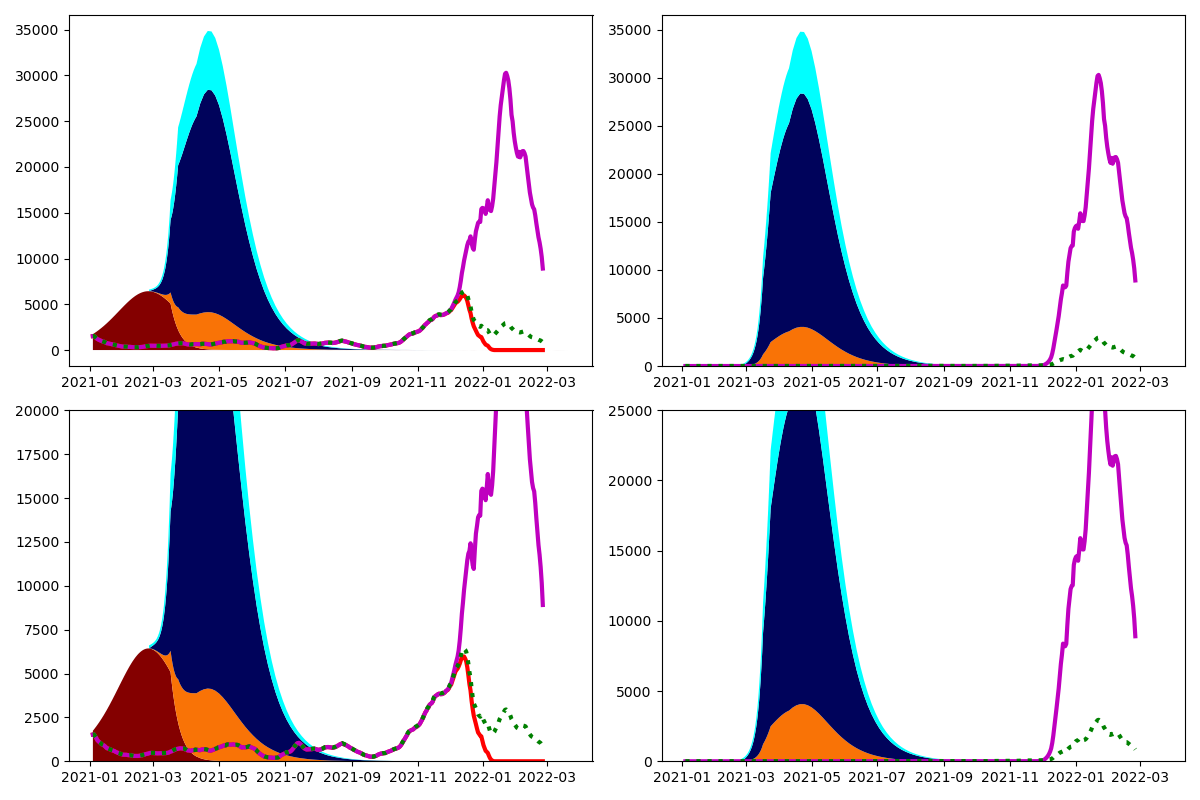

In [19]:
curSch = sch3
curSch.simulate()

curT = curSch.result.t
curDays = np.datetime64(df.iloc[0].Date)+np.array([np.timedelta64(int(np.round(x*24)),'h') for x in curT])

# plt.figure(figsize=(10,5))

fig,allAxes = plt.subplots(2,2)

ax1 = allAxes.flatten()[0]
ax1.stackplot(curDays,
                DKpop*gammas*curSch.result.Y,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) + pf.rnMean(df.Delta,7)),':',color='g',linewidth=3)

ax3 = allAxes.flatten()[2]
ax3.stackplot(curDays,
                DKpop*gammas*curSch.result.Y,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
ax3.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
ax3.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
ax3.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) + pf.rnMean(df.Delta,7)),':',color='g',linewidth=3)

ax3.set_ylim(top=20000,bottom=0)



ax2 = allAxes.flatten()[1]
ax2.stackplot(curDays,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
# ax2.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
ax2.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
ax2.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) ),':',color='g',linewidth=3)




ax4 = allAxes.flatten()[3]
ax4.stackplot(curDays,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
# ax4.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
ax4.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
ax4.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) ),':',color='g',linewidth=3)

ax4.set_ylim(top=25000,bottom=0)

fig.tight_layout()

# New try

In [20]:
# Initialize everything
DarkNumberRatio = 1.5
DarkNumberRatio = 1
# DarkNumberRatio = 2

# DKpop = 5800000
# # Numbers for weeks 44, i.e. 2021-11-01
# numVacc = 4423398
# DKpop = 5889508


# Numbers from 2021-11-01 for Region Hovedstaden
popCount = 1857872
numVacc = 1365172
preInf = 183799
# preInf = preInf * 0.95
preInf = preInf * 0.9

# iniInf = DarkNumberRatio * df.Total[0:5].sum()/DKpop
# iniInf = DarkNumberRatio * (pf.rnMean(df.Total,7)[0:5]).sum()/DKpop
iniInf = DarkNumberRatio * (pf.rnMean(df.Total,7)[0:8]).sum()/DKpop
# iniVacc = 0.7 # Approximately DK's vaccinationsrate at the end of summer 2021
iniVacc = numVacc/popCount 
# iniImmu = 0.05 # Approximation. Should only be "natural immunity"
iniImmu = DarkNumberRatio * (preInf/popCount)
# iniImmu = 0.10 # Approximation. Should only be "natural immunity"
iniImmu = iniImmu * (1-iniVacc) # For splitting previous infections between vaccinated and susceptible

iniVaccFull = iniVacc * 0.25 # Assuming 25% has full immunity (i.e. also toward omicron) due to vaccine
iniVaccFull = iniVacc * 0.5 # Assuming 50% has full immunity (i.e. also toward omicron) due to vaccine

# iniVacc = iniVacc * 0.95 # Assuming approximately 5% of vaccinations didn't provide immunity
iniVacc = iniVacc * 0.925 - iniVaccFull # Assuming approximately 7.5% of vaccinations didn't provide immunity


V_0 = iniVacc 
IS_0 = 0
IV_0 = 0
Y_0 = iniInf
R01_0 = iniImmu
R10_0 = 0
I01_0 = 0
Y10_0 = 0
R11_0 = iniVaccFull
S_0 = 1 - V_0 - IS_0 - IV_0 - Y_0 - R01_0 - R10_0 - I01_0 - Y10_0 - R11_0

init = {'S' : S_0,'V' : V_0,'IS' : IS_0,'IV' : IV_0,'Y' : Y_0,'R01' : R01_0,'R10' : R10_0,'I01' : I01_0,'Y10' : Y10_0}

# # gammas = 1/7
# gammas = 1/4.7
# gammas = 1/3.5
# gammas_I = gammas 
# gammas_Y = gammas
# # beta_Y = 4.2*gammas
# beta_Y = 4.3*gammas
# beta_Y =  4.8*gammas
# # beta_Y = 6.9*gammas
# # beta_Y = 7.2*gammas
# beta_I = 1.85*gammas
# # beta_I = 1.5*gammas

gammas_Y = 1/3
gammas_I = 1/4.7
# gammas = 1/(5.5)
# gammas = 1/(2)

beta_Y = 3.625*gammas_Y
beta_I = 2.5*gammas_I

pars = {'beta_IS_S' : beta_I,'beta_IV_S' : beta_I,'beta_I01_S' : beta_I,'beta_IS_V' : beta_I,'beta_IV_V' : beta_I,'beta_I01_V' : beta_I,'beta_IS_R01' : beta_I,'beta_IV_R01' : beta_I,'beta_I01_R01' : beta_I,'beta_Y_S' : beta_Y,'beta_Y10_S' : beta_Y,'beta_Y_R10' : beta_Y,'beta_Y10_R10' : beta_Y,'gamma_IS' : gammas_I,'gamma_IV' : gammas_I,'gamma_Y' : gammas_Y,'gamma_I01' : gammas_I,'gamma_Y10' : gammas_Y}

numDaysToSim = len(df.Date)    
tEnd = numDaysToSim+20
sch1 = pmf.Scheme('OmikronDeltaFull',init,pars,3,tEnd,Changes=[])


(0.0, 3500.0)

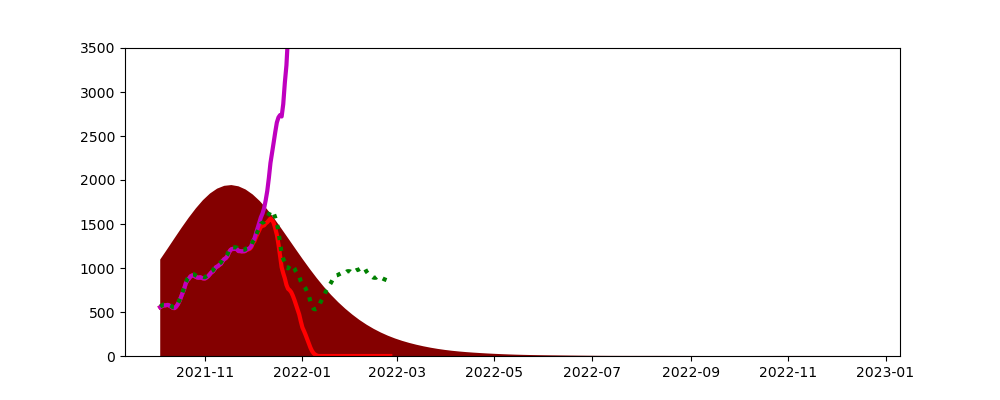

In [21]:
curSch = sch1
curSch.simulate()

curT = curSch.result.t
curDays = np.datetime64(dfCorrected.iloc[0].Date)+np.array([np.timedelta64(int(np.round(x*24)),'h') for x in curT])

# plt.figure(figsize=(10,5))

fig,ax1 = plt.subplots(figsize=(10,4))

ax1.stackplot(curDays,
                DKpop*gammas*curSch.result.Y,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
ax1.plot(pf.rnTime(dfCorrected.Date,7),DarkNumberRatio * pf.rnMean(dfCorrected.Delta,7),color='r',linewidth=3)
ax1.plot(pf.rnTime(dfCorrected.Date,7),DarkNumberRatio *( pf.rnMean(dfCorrected.Delta,7) + pf.rnMean(dfCorrected.Omikron,7)),color='m',linewidth=3)
ax1.plot(pf.rnTime(dfCorrected.Date,7),DarkNumberRatio *( pf.rnMean(dfCorrected.Reinfections,7) + pf.rnMean(dfCorrected.Delta,7)),':',color='g',linewidth=3)

ax1.set_ylim(top=3500,bottom=0)

In [22]:
tLock = DateRestrictions + 4
betaMult_Y_close = 0.5
# betaMult_I_close = 0.65
betaMult_I_close = 0.885
# betaMult_I_close = betaMult_Y_close
dictToMult = {'beta_IS_S' : betaMult_I_close,'beta_IV_S' : betaMult_I_close,'beta_I01_S' : betaMult_I_close,'beta_IS_V' : betaMult_I_close,'beta_IV_V' : betaMult_I_close,'beta_I01_V' : betaMult_I_close,'beta_IS_R01' : betaMult_I_close,'beta_IV_R01' : betaMult_I_close,'beta_I01_R01' : betaMult_I_close,'beta_Y_S' : betaMult_Y_close,'beta_Y10_S' : betaMult_Y_close,'beta_Y_R10' : betaMult_Y_close,'beta_Y10_R10' : betaMult_Y_close}
betaMultChange = pmf.Change(tLock, MultiplyParameters=dictToMult)

sch2 = sch1.copy()
sch2.addChange(betaMultChange)


In [23]:
tChange = 53
# tChange = 52
# tChange = 30
toAdd = iniInf/10
dictToAdd =  {  
    'S' : -toAdd,
    'IS' : toAdd,
}
addI = pmf.Change(tChange, AddVariables=dictToAdd)

tEnd = numDaysToSim+250
sch3 = sch2.copy()
sch3.addChange(addI)
sch3.sortChanges()
sch3.simulate()

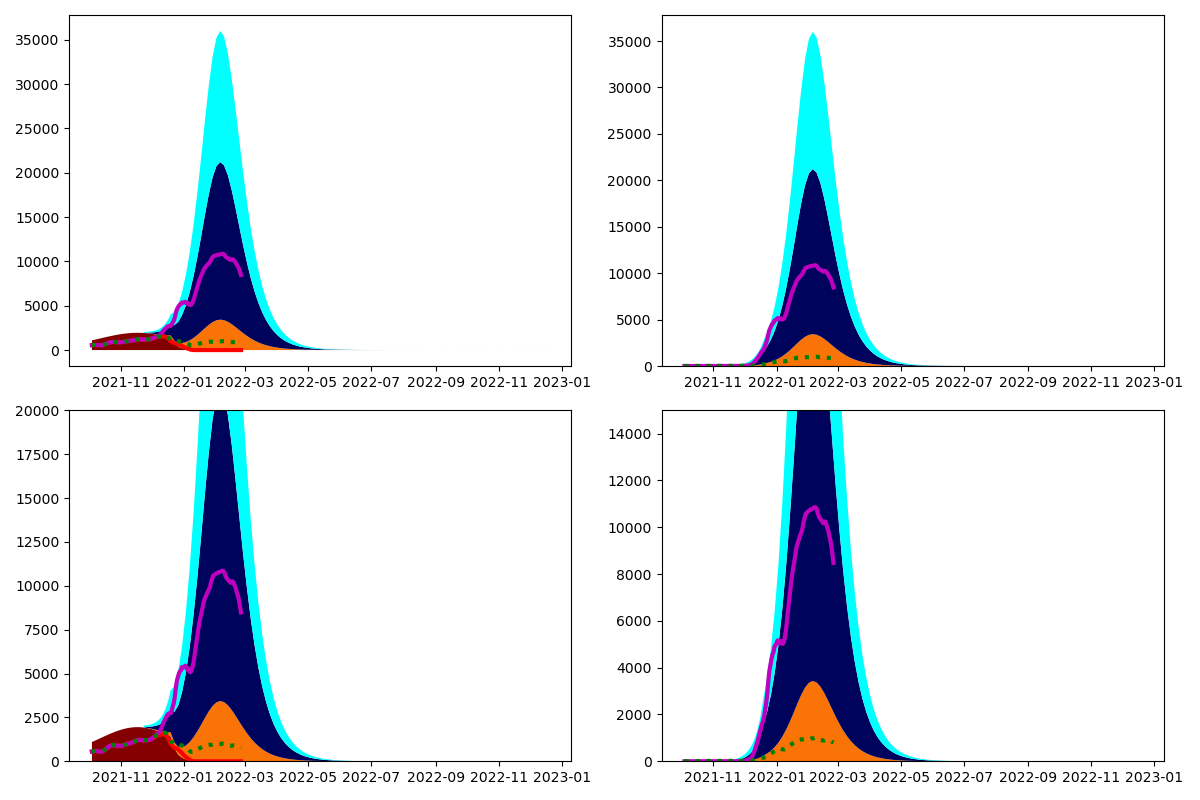

In [24]:
curSch = sch3
curSch.simulate()

curT = curSch.result.t
curDays = np.datetime64(dfCorrected.iloc[0].Date)+np.array([np.timedelta64(int(np.round(x*24)),'h') for x in curT])

# plt.figure(figsize=(10,5))

fig,allAxes = plt.subplots(2,2)

ax1 = allAxes.flatten()[0]
ax1.stackplot(curDays,
                DKpop*gammas*curSch.result.Y,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
ax1.plot(pf.rnTime(dfCorrected.Date,7),DarkNumberRatio * pf.rnMean(dfCorrected.Delta,7),color='r',linewidth=3)
ax1.plot(pf.rnTime(dfCorrected.Date,7),DarkNumberRatio *( pf.rnMean(dfCorrected.Delta,7) + pf.rnMean(dfCorrected.Omikron,7)),color='m',linewidth=3)
ax1.plot(pf.rnTime(dfCorrected.Date,7),DarkNumberRatio *( pf.rnMean(dfCorrected.Reinfections,7) + pf.rnMean(dfCorrected.Delta,7)),':',color='g',linewidth=3)

ax3 = allAxes.flatten()[2]
ax3.stackplot(curDays,
                DKpop*gammas*curSch.result.Y,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
ax3.plot(pf.rnTime(dfCorrected.Date,7),DarkNumberRatio * pf.rnMean(dfCorrected.Delta,7),color='r',linewidth=3)
ax3.plot(pf.rnTime(dfCorrected.Date,7),DarkNumberRatio *( pf.rnMean(dfCorrected.Delta,7) + pf.rnMean(dfCorrected.Omikron,7)),color='m',linewidth=3)
ax3.plot(pf.rnTime(dfCorrected.Date,7),DarkNumberRatio *( pf.rnMean(dfCorrected.Reinfections,7) + pf.rnMean(dfCorrected.Delta,7)),':',color='g',linewidth=3)

ax3.set_ylim(top=20000,bottom=0)



ax2 = allAxes.flatten()[1]
ax2.stackplot(curDays,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
# ax2.plot(pf.rnTime(dfCorrected.Date,7),DarkNumberRatio * pf.rnMean(dfCorrected.Delta,7),color='r',linewidth=3)
ax2.plot(pf.rnTime(dfCorrected.Date,7),DarkNumberRatio *( pf.rnMean(dfCorrected.Omikron,7)),color='m',linewidth=3)
ax2.plot(pf.rnTime(dfCorrected.Date,7),DarkNumberRatio *( pf.rnMean(dfCorrected.Reinfections,7) ),':',color='g',linewidth=3)




ax4 = allAxes.flatten()[3]
ax4.stackplot(curDays,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
# ax4.plot(pf.rnTime(dfCorrected.Date,7),DarkNumberRatio * pf.rnMean(dfCorrected.Delta,7),color='r',linewidth=3)
ax4.plot(pf.rnTime(dfCorrected.Date,7),DarkNumberRatio *( pf.rnMean(dfCorrected.Omikron,7)),color='m',linewidth=3)
ax4.plot(pf.rnTime(dfCorrected.Date,7),DarkNumberRatio *( pf.rnMean(dfCorrected.Reinfections,7) ),':',color='g',linewidth=3)

ax4.set_ylim(top=15000,bottom=0)

fig.tight_layout()

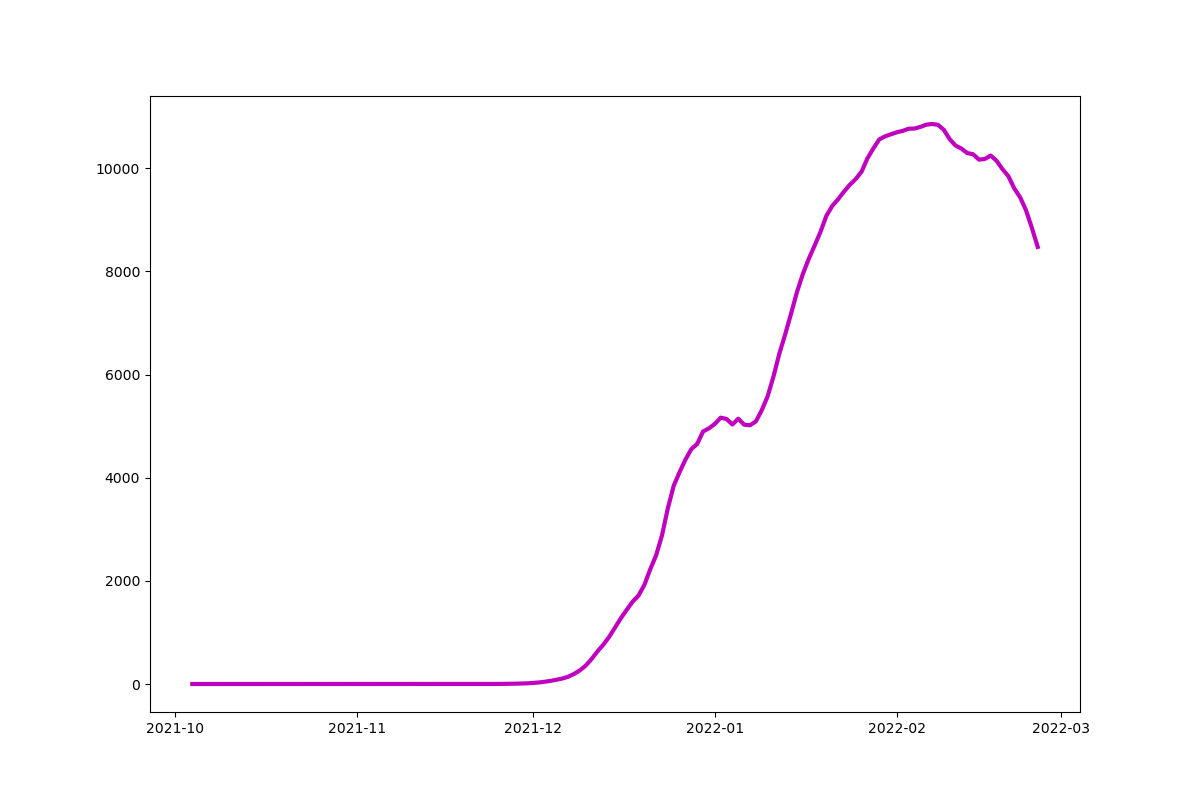

In [25]:
fig,ax = plt.subplots()
ax.plot(pf.rnTime(dfCorrected.Date,7),( pf.rnMean(dfCorrected.Omikron,7)),color='m',linewidth=3)

In [26]:
# curSch = sch3
# curSch.simulate()

# curT = curSch.result.t
# curDays = np.datetime64(df.iloc[0].Date)+np.array([np.timedelta64(int(np.round(x*24)),'h') for x in curT])

# # plt.figure(figsize=(10,5))

# fig,allAxes = plt.subplots(2,2)

# ax1 = allAxes.flatten()[0]
# ax1.stackplot(curDays,
#                 DKpop*gammas*curSch.result.Y,
#                 DKpop*gammas*curSch.result.I01,
#                 DKpop*gammas*curSch.result.IV,
#                 DKpop*gammas*curSch.result.IS,
#                 colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
#                 )
# ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
# ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
# ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) + pf.rnMean(df.Delta,7)),':',color='g',linewidth=3)

# ax3 = allAxes.flatten()[2]
# ax3.stackplot(curDays,
#                 DKpop*gammas*curSch.result.Y,
#                 DKpop*gammas*curSch.result.I01,
#                 DKpop*gammas*curSch.result.IV,
#                 DKpop*gammas*curSch.result.IS,
#                 colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
#                 )
# ax3.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
# ax3.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
# ax3.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) + pf.rnMean(df.Delta,7)),':',color='g',linewidth=3)

# ax3.set_ylim(top=20000,bottom=0)



# ax2 = allAxes.flatten()[1]
# ax2.stackplot(curDays,
#                 DKpop*gammas*curSch.result.I01,
#                 DKpop*gammas*curSch.result.IV,
#                 DKpop*gammas*curSch.result.IS,
#                 colors=['xkcd:orange','xkcd:dark blue','xkcd:cyan'],
#                 )
# # ax2.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
# ax2.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
# ax2.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) ),':',color='g',linewidth=3)




# ax4 = allAxes.flatten()[3]
# ax4.stackplot(curDays,
#                 DKpop*gammas*curSch.result.I01,
#                 DKpop*gammas*curSch.result.IV,
#                 DKpop*gammas*curSch.result.IS,
#                 colors=['xkcd:orange','xkcd:dark blue','xkcd:cyan'],
#                 )
# # ax4.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
# ax4.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
# ax4.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) ),':',color='g',linewidth=3)

# ax4.set_ylim(top=25000,bottom=0)

# fig.tight_layout()

In [27]:

curT = curSch.result.t
curDays = np.datetime64(df.iloc[0].Date)+np.array([np.timedelta64(int(np.round(x*24)),'h') for x in curT])
curSch.result.t

array([  3.        ,   3.50505051,   4.01010101,   4.51515152,
         5.02020202,   5.52525253,   6.03030303,   6.53535354,
         7.04040404,   7.54545455,   8.05050505,   8.55555556,
         9.06060606,   9.56565657,  10.07070707,  10.57575758,
        11.08080808,  11.58585859,  12.09090909,  12.5959596 ,
        13.1010101 ,  13.60606061,  14.11111111,  14.61616162,
        15.12121212,  15.62626263,  16.13131313,  16.63636364,
        17.14141414,  17.64646465,  18.15151515,  18.65656566,
        19.16161616,  19.66666667,  20.17171717,  20.67676768,
        21.18181818,  21.68686869,  22.19191919,  22.6969697 ,
        23.2020202 ,  23.70707071,  24.21212121,  24.71717172,
        25.22222222,  25.72727273,  26.23232323,  26.73737374,
        27.24242424,  27.74747475,  28.25252525,  28.75757576,
        29.26262626,  29.76767677,  30.27272727,  30.77777778,
        31.28282828,  31.78787879,  32.29292929,  32.7979798 ,
        33.3030303 ,  33.80808081,  34.31313131,  34.81

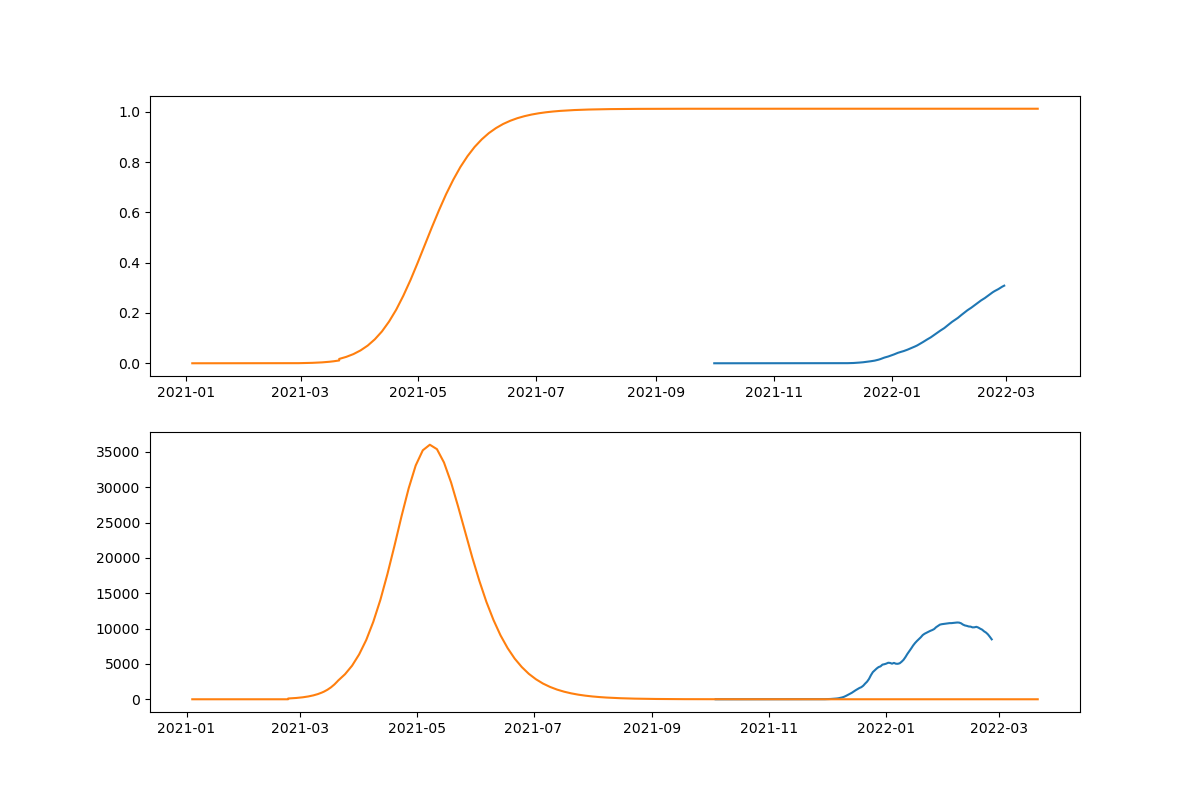

In [28]:
modelOmikron = DKpop*gammas*curSch.result.I01 + DKpop*gammas*curSch.result.IV + DKpop*gammas*curSch.result.IS,

# ax4.stackplot(curDays,
# plt.figure()

fig,(ax1,ax2) = plt.subplots(2,1)

ax1.plot(dfCorrected.Date,DarkNumberRatio*np.cumsum(dfCorrected.Omikron)/popCount)
# ax1.plot(curDays,np.cumsum(modelOmikron))
ax1.plot(curDays[:-1],cumtrapz(modelOmikron[0],curT)/popCount)

# ax2.plot(dfCorrected.Date,DarkNumberRatio*dfCorrected.Omikron)
ax2.plot(pf.rnTime(dfCorrected.Date),DarkNumberRatio*pf.rnMean(dfCorrected.Omikron))
ax2.plot(curDays,modelOmikron[0])